In [1]:
'''!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1'''

'!pip install gym pyvirtualdisplay > /dev/null 2>&1\n!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1\n!apt-get update > /dev/null 2>&1\n!apt-get install cmake > /dev/null 2>&1\n!pip install --upgrade setuptools 2>&1\n!pip install ez_setup > /dev/null 2>&1\n!pip install gym[atari] > /dev/null 2>&1'

In [2]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from scipy.stats import bernoulli,norm,beta
import statsmodels.stats.proportion as smp
from scipy.signal import unit_impulse
import numpy as np
import matplotlib.pyplot as plt


#display = Display(visible=0, size=(1400, 900))
#display.start()

## The plant watering problem

In [3]:


def dirac(h_space,h):
  d=np.zeros(h_space)
  d[h]=1
  return d

class plant:
    def __init__(self, H = 0, W =0, idp:str='p'):
        self.h = H
        self.w = W
        self.id = idp
    def __repr__(self):
        return self.__str__()
    def __str__(self):
        return self.id+'('+str(self.h)+','+str(self.w)+')' 
        
class Policy:
    def __init__(self,nS:int,actions:tuple, params:list):
        self.pi = {}
        for p in params:
            self.pi[p]=[(np.random.choice(actions[0],size=1)[0],np.random.choice(actions[1],size=1)[0]) for s in range(nS)]
    def __repr__(self):
        return self.__str__()
    def __str__(self):
        s = ''
        for k,v in self.pi.items():
            s= s+'c= '+str(k)+': \n'
            for i in range(len(v)):
                s = s+f'\t state({i}) = '+str(v[i])+'\n'
        return s

class garden:
  def __init__(self, n_plants, H, W, K, G, C, C_o, Pen = 0., rain_gen=None, fullmodel=True):
    self.K = K
    self.H = H
    self.W = W
    self.n_plants = n_plants
    self.G = G
    self.C = C
    self.C_o = C_o
    self.q_arr = [0.7,0.6,0.9,0.5]
    self.q=0.3
    self.Pen = Pen
    self.rain_gen = rain_gen
    self.fullmodel = fullmodel
    
    self.reset()
    
  def reset(self,):
    self.plants = [plant(0,0,'p'+str(i)) for i in range(self.n_plants)]
    self.grown_plants = 0
    self.rain_P, self.rain_E, self.rain_C = self.rain_gen(self.K)#self.init_rain_params()
    #self.ci = self.calculate_confidence_intervals()


  ''' def init_rain_params(self):
    theta_values = [0.2,0.5,0.8]
    # For fixed probabilities
    thetas = [theta_values[np.random.randint(len(theta_values))] for i in range(self.K)]
    # for random probabilities
    #thetas = np.random.random(K)
    rain = [bernoulli.rvs(p, size=1)[0] for p in thetas]
    return thetas, rain'''
  @property
  def nS(self):
    return (self.H,self.W)
  @property
  def nA(self):
    return (2,2)
  '''def calculate_confidence_intervals(self, N=100, alpha = 0.5):
    #assuming normal approximation ~100
    ci = [smp.proportion_confint(theta*N,N, alpha = alpha) for theta in self.thetas]
    return ci'''

  def get_reward(self, h, oldh, w, oldw, c, a,o):
    reward = float((h==self.H-1)*self.G -a*self.C - o*self.C_o)
    if h <= oldh and oldh != self.H-1 and w <= oldw:
        reward -= self.Pen
    return reward
  def __update_plant__(self, plant_id, state:tuple ):
    self.plants[plant_id].h = state[0]
    self.plants[plant_id].w = state[1]

  def __transitions_from_H__(self,h,a,c):
    assert(h<self.H)
    Space = np.zeros([self.H,self.W])
    weights = [1/self.W]*self.W
    for w in range(self.W):
        if h == self.H-1:
            Space += (weights[w]*dirac(self.H,0).reshape((self.H,1))@dirac(self.W,w).reshape((1,self.W)))
        else:
            Wspace = (1 - self.q) * dirac(self.W, np.clip(c+a+w-1,0,3)) + self.q*dirac(self.W,np.clip(c+a+w,0,3))
            coef = int(w == 0 or w == self.W-1)
            Hspace = ((1-self.q_arr[w])*dirac(self.H,np.clip(h-1*coef,0,H))+self.q_arr[w]*dirac(self.H,np.clip(h+1*(1-coef),0,H)))#*pw_ca
            for i,rh in enumerate(Hspace):
                for j,rw in enumerate(Wspace):
                    Space[i,j] += (rh*rw*weights[w])
    return Space
  def __transitionsHW__(self, h,w, a, c):
    assert(h<self.H and w < self.W)
    H = self.H-1
    Hspace = np.zeros(self.H)  
    Wspace = np.zeros(self.W)
    Space = np.zeros([self.H,self.W])
    Wspace = (1 - self.q) * dirac(self.W, np.clip(c+a+w-1,0,3)) + self.q*dirac(self.W,np.clip(c+a+w,0,3))
    if h == H:
      Space = dirac(self.H,0).reshape((self.H,1))@dirac(self.W,w).reshape((1,self.W))
    else:
      coef = int(w == 0 or w == self.W-1)
      Hspace = ((1-self.q_arr[w])*dirac(self.H,np.clip(h-1*coef,0,H))+self.q_arr[w]*dirac(self.H,np.clip(h+1*(1-coef),0,H)))#*pw_ca
      for i,rh in enumerate(Hspace):
        for j,rw in enumerate(Wspace):
            Space[i,j] = rh*rw
    return Space
  def dynamics(self, plant_id, a, c, o=1):
    H = self.H-1
    h = self.plants[plant_id].h
    w = self.plants[plant_id].w
    Space = self.__transitionsHW__(h,w, a, c)
    flat = Space.flatten()
    sample_index = np.random.choice(a=flat.size, p=flat)
    next_h, next_w = np.unravel_index(sample_index, Space.shape)
    self.__update_plant__(plant_id,(next_h,next_w))
    return sample_index, self.get_reward(next_h, h,next_w,w, c, a,o) if h != H else self.get_reward(h, h,w,w, c, 0,0)

  def dynamics_from_state(self, state, a, c, o, exploration=False):
    H = self.H-1
    h = int(state/self.W)
    w = int(state%self.W)
    Space = None
    if o==1 and exploration==True and self.fullmodel==False:
        Space = self.__transitions_from_H__(h, a, c)  
    else: 
        Space =  self.__transitionsHW__(h,w, a, c)
    flat = Space.flatten()
    sample_index = np.random.choice(a=flat.size, p=flat)
    next_h, next_w = np.unravel_index(sample_index, Space.shape)
    return sample_index, self.get_reward(next_h, h,next_w,w, c, a,o) if h != H else self.get_reward(h, h,w,w, c, 0,0)

  def transitions(self, h,w, a, c, o):
    H = self.H-1
    Hspace = np.zeros(self.H)  
    Wspace = np.zeros(self.W)
    P =[]
    Space = None
    if o==1 and self.fullmodel==False:
        Space = self.__transitions_from_H__(h, a, c)  
    else: 
        Space =  self.__transitionsHW__(h,w, a, c)
    if h == H:
      for i in range(Space.shape[0]):
        for j in range(Space.shape[1]):
            p = Space[i,j]
            if p > 0.0:
                P.append((p,[i,j],self.get_reward(h, h,w,w, c, 0,0)))
    else:
      for i in range(Space.shape[0]):
        for j in range(Space.shape[1]):
            p = Space[i,j]
            if p > 0.0:
                P.append((p,[i,j],self.get_reward(i, h,j,w, c, a,o)))

    return P

  def __str__(self):
    out_str = "__"
    for p in self.plants:
      out_str += (str(p)+'__')
    return out_str

  def observations(self):
     a = np.zeros((self.n_plants,self.H,self.W),dtype=np.float16)
     for i in range(self.n_plants):
        p = self.plants[i]
        a[i,p.h,p.w] = 1.
     return a
     




**Q0:**  Build a rain generator using these characteristics, with parameter $K$. Generate $\theta_{t'}^-,\theta_{t'}^+,\alpha_{t'}$ randomly making sure the confidence set indeed contains $\theta_{t}$ with probability at least $\alpha_{t}$

In [4]:
theta_values = np.array([0.2,0.5,0.8])
min_t = min(theta_values)
max_t = max(theta_values)
mid_t = theta_values[1]
a_ = round(np.random.uniform(1.1, 5),2)
b_ = round(np.random.uniform(1.1, 5),2)
mu_ = a_/(a_+b_)
std_ = (a_*b_/(((a_+b_)**2)*(a_+b_+1)))**0.5
def observe_rain(theta=0.5, conf=None):
    if conf is None:
        return int(bernoulli.rvs(theta, size=1)[0])
    p = np.random.uniform(conf[0],conf[1])
    return int(bernoulli.rvs(p, size=1)[0])
def estimate_w_level(rain_hist, actions_hist,W):
    w = 0
    a = 0 # we could also save previous actions and be more precise
    for i,c in enumerate(rain_hist):
      a = actions_hist[i]
      wspace = (1 - 0.3) * dirac(W, np.clip(c+a+w-1,0,3)) + 0.3*dirac(W,np.clip(c+a+w,0,3))
      w = np.argmax(wspace)
      #w = np.random.choice([i for i in range(wspace.shape[0])], p=wspace)
    return w
def rain_generator_E(K):
    # For fixed probabilities
    thetas = [np.random.choice(theta_values)]*K
    rain = [bernoulli.rvs(p, size=1)[0] for p in thetas]
    return None, rain,None

def rain_generator_P(K):
    thetas = [np.random.choice(theta_values)]*K
    #rain = [bernoulli.rvs(p, size=1)[0] for p in thetas]
    return thetas, None, None

def rain_generator_C(K):
    confidence = []
    theta_0 = None
    theta_1 = None
    alpha = 0.
    for i in range(K):
        while alpha < 0.5:
            tmp0 = np.random.uniform(0, 1)
            tmp1 = np.random.uniform(0, 1)
            theta_0 = min(tmp0,tmp1)
            theta_1 = max(tmp0,tmp1)
            alpha = 1-beta.cdf(theta_1,a_,b_)-beta.cdf(theta_0,a_,b_)
            count = 0
            for v in theta_values:
                if v >= theta_0 and v<=theta_1:
                    count+=1
            if count == 0:
                alpha = 0.
                
        confidence.append((theta_0,theta_1,alpha))
    return None, None, confidence

In [5]:
rain_generator_C(10)

(None,
 None,
 [(0.1639783123457702, 0.2363343297043815, 0.6736553429405236),
  (0.1639783123457702, 0.2363343297043815, 0.6736553429405236),
  (0.1639783123457702, 0.2363343297043815, 0.6736553429405236),
  (0.1639783123457702, 0.2363343297043815, 0.6736553429405236),
  (0.1639783123457702, 0.2363343297043815, 0.6736553429405236),
  (0.1639783123457702, 0.2363343297043815, 0.6736553429405236),
  (0.1639783123457702, 0.2363343297043815, 0.6736553429405236),
  (0.1639783123457702, 0.2363343297043815, 0.6736553429405236),
  (0.1639783123457702, 0.2363343297043815, 0.6736553429405236),
  (0.1639783123457702, 0.2363343297043815, 0.6736553429405236)])

### Watering level observation

In [6]:
import itertools
import copy

def regret_function(env,state, allactions, actiontaken,c):
    _,r = env.dynamics_from_state(state, actiontaken[0], c, actiontaken[1])
    regr = 0.
    for a in allactions:
        new_s, r2 = env.dynamics_from_state(state, a[0], c, a[1])
        regr += (r2-r)
    return regr
def average_reward(env,state, pi,rain,istheta=False, conf = None):
    tot = 0.
    curr_state = state
    for t in range(len(rain)):
        confidence = conf[t] if conf is not None else None
        c = rain[t] if istheta==False else observe_rain(rain[t],confidence)
        curr_state, r = env.dynamics_from_state(curr_state, pi[c][curr_state][0], c, pi[c][curr_state][1])
        tot += r
    return tot/len(rain)
def average_regret(env,state, pi,rain,istheta=False, conf = None):
    tot = 0.
    curr_state = state
    allactions = [(action,o) for action,o in itertools.product(range(env.nA[0]), range(env.nA[1]))]
    for t in range(len(rain)):
        confidence = conf[t] if conf is not None else None
        c = rain[t] if istheta==False else observe_rain(rain[t],confidence)
        tmp, r = env.dynamics_from_state(curr_state, pi[c][curr_state][0], c, pi[c][curr_state][1])
        tot += regret_function(env,curr_state, allactions, pi[c][curr_state],c)
        curr_state = tmp
    return tot/len(rain)
def value_function(env,c,pi,GAMMA=1., T=20, istheta=False, conf = None):
    """
    pi : int array
    For each index i, pi[i] is the action (int) chosen in state i

    return:
    ------
    V_pi : float array
    For each index i, V_pi[i] is the value (float) of the state i
    """
    # Compute both the reward vector r_pi and
    # transition matrix P_pi associated to the policy on the given env
    r_pi = np.zeros(env.nS[0]*env.nS[1])
    P_pi = np.zeros((env.nS[0]*env.nS[1], env.nS[0]*env.nS[1]))
    
    for t in range(T):
        for h in range(env.nS[0]):
            for w in range(env.nS[1]):
                confidence = conf[t] if conf is not None else None
                rain = c[t] if istheta==False else observe_rain(c[t],confidence)
                a = pi[rain][h*env.nS[1] + w][0]
                o = pi[rain][h*env.nS[1] + w][1]
                transitions_info = env.transitions(h,w,a,rain ,o)
                for transition in transitions_info:
                    proba = transition[0]
                    next_state = transition[1]
                    reward = transition[2]
                    P_pi[h*env.nS[1] + w,next_state[0]*env.nS[1] + next_state[1]] += proba
                    r_pi[h*env.nS[1] + w] += reward*proba
    # Compute the value function of the policy pi
    Id = np.eye(env.nS[0]*env.nS[1])
    return np.linalg.inv(Id - GAMMA*P_pi) @ r_pi

def value_function_optimal(env,c,pi,epsilon, max_iter,GAMMA=1.,istheta=False, conf = None):
   
    V_opt_old = np.zeros(env.nS)
    V_opt = np.zeros(env.nS)
    delta_linf = np.zeros((max_iter))
    i = 0
    stop = False
    regrets = np.zeros((max_iter))
    rewards = np.zeros((max_iter))
    T = min(max_iter,100)
    while (not stop) and (i < max_iter):
        confidence = conf[i] if conf is not None else None
        rain = c[i] if istheta==False else observe_rain(c[i],confidence)
        for h in range(env.nS[0]):
            for w in range(env.nS[1]):
                # Q is the local (slice) state-action value function for 'state'
                Q = np.zeros(env.nA)
                for action,o in itertools.product(range(env.nA[0]), range(env.nA[1])):
                    transitions_info = env.transitions(h,w,action,rain,o)
                    for transition in transitions_info:
                        proba  = transition[0]
                        next_state = transition[1]
                        reward  = transition[2]
                        Q[action,o] += proba*(reward + GAMMA*V_opt_old[next_state[0],next_state[1]])
                #print(Q,h,w,np.argmax(Q))
                V_opt[h,w] = np.max(Q)
                pi[rain][h*env.nS[1] + w] = np.unravel_index(np.argmax(Q), Q.shape)
        delta_linf[i] = np.max(np.abs(V_opt_old-V_opt))
        np.copyto(V_opt_old, V_opt)
        rewards[i] = average_reward(env,0, pi,c[0:T],istheta, conf)
        regrets[i] = average_regret(env,0, pi,c[0:T],istheta, conf)
        if delta_linf[i] < epsilon:
            delta_linf = delta_linf[:i+1]
            rewards = rewards[:i+1]
            regrets = regrets[:i+1]
            stop = True
        i += 1
    return V_opt, delta_linf,pi,rewards,regrets

'''def value_function_optimal_from_state(env,state,V,c,o,GAMMA=1., T=20, istheta=False, conf = None):
    """
    pi : int array
    For each index i, pi[i] is the action (int) chosen in state i

    return:
    ------
    V_pi : float array
    For each index i, V_pi[i] is the value (float) of the state i
    """
    # Compute both the reward vector r_pi and
    # transition matrix P_pi associated to the policy on the given env
    Q = np.zeros((env.nA))
    next_states = [state]
    t = 0
    while t < T:
        s = next_states.pop(0)
        beststate = np.full((env.nA),s)
        bestr = np.zeros((env.nA))
        confidence = conf[t] if conf is not None else None
        rain = c[t] if istheta==False else observe_rain(c[t],confidence)
        for action in range(env.nA):
            transitions_info = env.transitions(s,action,rain ,o[t])
            for transition in transitions_info:
                proba = transition[0]
                next_state = transition[1]
                reward = transition[2]
                Q[action] +=  proba*(reward + GAMMA*V[next_state])
                if proba >= bestr[action]:
                    beststate[action] = next_state
                    bestr[action] = proba
        next_states.append(beststate[np.argmax(Q)])
        t+=1
    return np.max(Q),np.argmax(Q)

def value_function_optimal_2(env,c,o,epsilon, max_iter,GAMMA=1.,T=20,istheta=False, conf = None):
    """
    epsilon : float
    Used as a threshold for the stopping rule

    max_iter : int
    Hard threshold on the number of loops

    returns:
    -------
    V_opt : float array, (env.nS,) size
    Optimal value function on the FrozenLake MDP given a discount GAMMA
    V_opt[state index] = Value of that state
    """
    V_opt_old = np.zeros((env.nS))
    V_opt = np.zeros((env.nS))
    delta_linf = np.zeros((max_iter))
    pi = np.zeros((env.nS)) 
    i = 0
    stop = False
    while (not stop) and (i < max_iter):
        start = np.random.randint(low=0, high=T-1)
        end = np.random.randint(low=start+1, high=T)
        for state in range(env.nS):
            v, a = value_function_optimal_from_state(garden_1,state,V_opt,c[start:end],o[start:end],GAMMA, len(c[start:end]),istheta, conf)
            V_opt[state] = v
            pi[state] = a
        delta_linf[i] = np.max(np.abs(V_opt_old-V_opt))
        np.copyto(V_opt_old, V_opt)
        if delta_linf[i] < epsilon:
            delta_linf = delta_linf[:i+1]
            stop = True
        i += 1
    return V_opt, delta_linf,pi
'''

def policy_improvement(env,V,pi,c,GAMMA=1.):
    """
    V : float array, size (env.nS,)
    Value function of a policy

    returns:
    -------
    pi : int array, size (env.nS,)
    A policy that is greedy with respect to V
    """
    # Compute state-value function associated to V
    
    Q = np.zeros((env.nS[0]*env.nS[1], env.nA[0],env.nA[1]))
    for h,w in itertools.product(range(env.nS[0]), range(env.nS[1])):
        for action,o in itertools.product(range(env.nA[0]), range(env.nA[1])):
            transitions_info = env.transitions(h,w,action,c,o)
            for transition in transitions_info:
                proba  = transition[0]
                next_state = transition[1]
                reward  = transition[2]
                Q[h*env.nS[1]+w, action,o] += proba*(reward + GAMMA*V[next_state[0]*env.nS[1]+next_state[1]])
        # Compute the/a greedy policy with respect to the Q/V value function
        pi[c][h*env.nS[1]+w] = np.unravel_index(np.argmax(Q[h*env.nS[1]+w]), Q[h*env.nS[1]+w].shape)
    return pi

def policy_iteration(env,pi,rain,epsilon, max_iter, GAMMA=1., T=30,istheta=False, conf = None):
    """
    epsilon : float
    Used as a threshold for the stopping rule

    max_iter : int
    Hard threshold on the number of loops

    returns:
    -------
    pi : int array, size (env.nS,)
    An optimal policy
    """
    #pi = np.ones(env.nS,dtype=np.int16)
    pi_old = copy.deepcopy(pi)
    V_pi = np.zeros((env.nS[0]*env.nS[1]))
    stop = False
    i = 0
    c = rain
    if istheta == True:
        for i in range(len(rain)):
            confidence = conf[i] if conf is not None else None
            c[i] = observe_rain(rain[i],confidence)
    c = np.array(c).astype(np.int16)
    while (not stop) and (i < max_iter):
        pi_old = copy.deepcopy(pi)
        V_pi_old = np.copy(V_pi)

        # policy evaluation
        V_pi = value_function(env,c,pi,GAMMA,min(T,max_iter))/min(T,max_iter) # test value_function_2 too !
        # policy improvement
        pi = policy_improvement(env,V_pi,pi,c[i],GAMMA)
        i += 1
        #stop = np.array_equal(pi, pi_old)
        # or, other criterion
        stop = np.array_equal(pi, pi_old) or np.max(np.abs(V_pi - V_pi_old)) < epsilon
    return pi,i

**We first consider the (E) situation and the Fully-observed model.**

**Q1.** If $c_t = 0$ for all time $t$,what is the value of the game with finite horizon T? With discount $\gamma$?

Value function of the constant action (1,1) policy with c=0 and gamma=0.9, with time horizon = 100:
[ 2.14444527e+00 -4.55391137e+00 -8.07106132e+00  1.12359551e-01
 -2.09334713e+00  5.11004908e+00  8.77300126e-01  1.12359551e-01
  1.62581951e+00 -3.27513003e+00  4.08571688e-02  1.12359551e-01
 -8.73402094e-01  2.29863465e+00  1.19043195e-01  1.12359551e-01
  7.48253441e-01 -1.28896108e+00  1.11734801e-01  1.12359551e-01
  6.93000075e+02  9.01479768e+01 -2.26395519e+02  5.10112360e+02]
Value estimate of the starting height: 2.144
Value function of the constant action (0,1) policy with c=0 and gamma=0.9, with time horizon = 100:
[-3.04169042e-15 -1.87074404e+01  2.49294372e+01 -6.04059440e+01
  1.32460712e-15  1.13168467e+01 -2.32999331e+01  6.11320692e+01
 -5.76845035e-16 -6.84599366e+00  1.46700244e+01 -4.42752648e+01
  2.51206709e-16  4.14140357e+00 -8.91468577e+00  3.33138326e+01
 -1.09396470e-16 -2.50529352e+00  5.39564880e+00 -2.71109661e+01
  5.00000000e+02 -1.18366964e+03  2.743

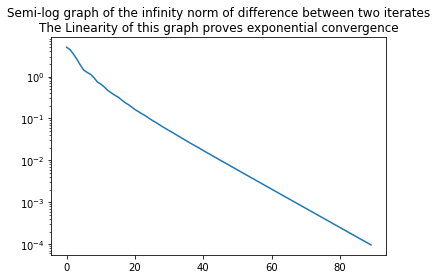

Number of iterations: 90
Last residual 9.603245142741912e-05


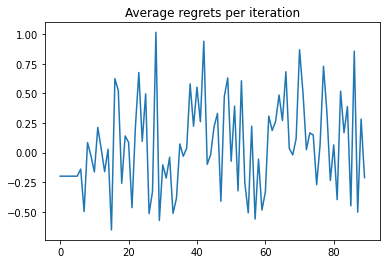

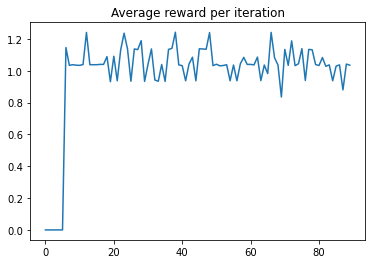

Policy from optimal value iteration
 c= 0: 
	 state(0) = (1, 0)
	 state(1) = (1, 0)
	 state(2) = (0, 0)
	 state(3) = (0, 0)
	 state(4) = (1, 0)
	 state(5) = (1, 0)
	 state(6) = (0, 0)
	 state(7) = (0, 0)
	 state(8) = (1, 0)
	 state(9) = (1, 0)
	 state(10) = (0, 0)
	 state(11) = (0, 0)
	 state(12) = (1, 0)
	 state(13) = (1, 0)
	 state(14) = (0, 0)
	 state(15) = (0, 0)
	 state(16) = (1, 0)
	 state(17) = (1, 0)
	 state(18) = (0, 0)
	 state(19) = (0, 0)
	 state(20) = (0, 0)
	 state(21) = (0, 0)
	 state(22) = (0, 0)
	 state(23) = (0, 0)



In [8]:
H=6
W=4
K=100
G=5
C=0.1
C_o=0.
GAMMA = 0.9
T = 100
epsilon = 1e-4
garden_1 = garden(n_plants=1, H=H, W=W, K=K, G=G, C=C,C_o=C_o,rain_gen = rain_generator_E)

c = np.zeros(T,dtype=np.int16)
pi = Policy(garden_1.nS[0]*garden_1.nS[1],(2,2), [0])
pi.pi[0] = [(1,1)]*garden_1.nS[0]*garden_1.nS[1]

V_simple_pi = value_function(garden_1,c,pi.pi,GAMMA,T)
print(f"Value function of the constant action (1,1) policy with c=0 and gamma={GAMMA}, with time horizon = {T}:\n{V_simple_pi}")
print(f"Value estimate of the starting height: {V_simple_pi[0]:.3f}")


pi.pi[0] = [(0,1)]*garden_1.nS[0]*garden_1.nS[1]
V_simple_pi = value_function(garden_1,c,pi.pi,GAMMA,T)
print(f"Value function of the constant action (0,1) policy with c=0 and gamma={GAMMA}, with time horizon = {T}:\n{V_simple_pi}")
print(f"Value estimate of the starting height: {V_simple_pi[0]:.3f}")

max_iter = 1000
c = np.zeros(max_iter,dtype=np.int16)
V_opt, delta_linf,pi.pi,rewards,regrets = value_function_optimal(garden_1,c,pi.pi,epsilon, max_iter,GAMMA)
print(f"Optimal value function with c_t=0 and gamma={GAMMA} with time horizon 1:\n{V_opt}")

plt.figure()
plt.title("Semi-log graph of the infinity norm of difference between \
two iterates\nThe Linearity of this graph proves exponential convergence")
plt.semilogy(delta_linf)
plt.show()
print("Number of iterations:", delta_linf.size)
print("Last residual", delta_linf[-1])
plt.figure()
plt.title("Average regrets per iteration")
plt.plot(regrets)
plt.show()
plt.figure()
plt.title("Average reward per iteration")
plt.plot(rewards)
plt.show()
print("Policy from optimal value iteration\n", pi)
#max_iter = 10
#pi.pi,tot_iter = policy_iteration(garden_1,pi.pi,c,epsilon, max_iter, GAMMA,T)
#print("Tot iterations", tot_iter)
#print("Policy from policy iteration\n", pi)

**Q2.** What happens with $c_t = 1$ instead?

Value function of the constant action (1,1) policy with c=1 and gamma=0.9, with time horizon = 100:
[1.12359551e-01 1.12359551e-01 1.12359551e-01 1.12359551e-01
 1.12359561e-01 1.12359551e-01 1.12359551e-01 1.12359551e-01
 1.12359590e-01 1.12359551e-01 1.12359551e-01 1.12359551e-01
 6.96130849e+07 1.57852811e+06 1.12359551e-01 1.12359551e-01
 7.82599105e+07 1.08019211e+06 4.17601124e+04 1.12359551e-01
 5.10112360e+02 5.10112360e+02 5.10112360e+02 5.10112360e+02]
Value estimate of the starting height: 0.112
Value function of the constant action (0,1) policy with c=1 and gamma=0.9, with time horizon = 100:
[ 1.99267027e+00 -4.57576135e+00 -8.02469072e+00  0.00000000e+00
 -2.16292358e+00  4.90075159e+00  7.50103366e-01  0.00000000e+00
  1.48410405e+00 -3.32178397e+00 -7.01154821e-02  0.00000000e+00
 -9.66641268e-01  2.14386890e+00  6.55400450e-03  0.00000000e+00
  6.23559742e-01 -1.37413984e+00 -6.12631814e-04  0.00000000e+00
  6.79340324e+02  8.81814781e+01 -2.22222165e+02  5.00000000e+0

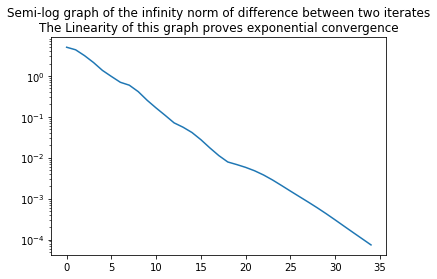

Number of iterations: 35
Last residual 7.40454867598217e-05


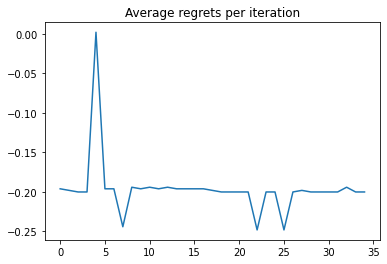

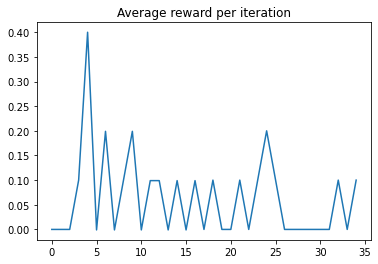

Policy from optimal value iteration
 c= 1: 
	 state(0) = (0, 0)
	 state(1) = (0, 0)
	 state(2) = (0, 0)
	 state(3) = (0, 0)
	 state(4) = (1, 0)
	 state(5) = (0, 0)
	 state(6) = (0, 0)
	 state(7) = (0, 0)
	 state(8) = (1, 0)
	 state(9) = (0, 0)
	 state(10) = (0, 0)
	 state(11) = (0, 0)
	 state(12) = (1, 0)
	 state(13) = (0, 0)
	 state(14) = (0, 0)
	 state(15) = (0, 0)
	 state(16) = (1, 0)
	 state(17) = (0, 0)
	 state(18) = (0, 0)
	 state(19) = (0, 0)
	 state(20) = (0, 0)
	 state(21) = (0, 0)
	 state(22) = (0, 0)
	 state(23) = (0, 0)



In [11]:
H=6
W=4
K=100
G=5
C=0.1
C_o=0.
GAMMA = 0.9
T = 100
garden_1 = garden(n_plants=1, H=H, W=W, K=K, G=G, C=C,C_o=C_o,rain_gen = rain_generator_E)

c = np.ones(T,dtype=np.int16)
pi = Policy(garden_1.nS[0]*garden_1.nS[1],(2,2), [1])
pi.pi[1] = [(1,0)]*garden_1.nS[0]*garden_1.nS[1]

V_simple_pi = value_function(garden_1,c,pi.pi,GAMMA,T)
print(f"Value function of the constant action (1,1) policy with c=1 and gamma={GAMMA}, with time horizon = {T}:\n{V_simple_pi}")
print(f"Value estimate of the starting height: {V_simple_pi[0]:.3f}")


pi.pi[1] = [(0,0)]*garden_1.nS[0]*garden_1.nS[1]
V_simple_pi = value_function(garden_1,c,pi.pi,GAMMA,T)
print(f"Value function of the constant action (0,1) policy with c=1 and gamma={GAMMA}, with time horizon = {T}:\n{V_simple_pi}")
print(f"Value estimate of the starting height: {V_simple_pi[0]:.3f}")

max_iter = 1000
c = np.ones(max_iter,dtype=np.int16)
V_opt, delta_linf,pi.pi,rewards,regrets = value_function_optimal(garden_1,c,pi.pi,1e-4, max_iter,GAMMA)
print(f"Optimal value function with c_t=0 and gamma={GAMMA} with time horizon 1:\n{V_opt}")

plt.figure()
plt.title("Semi-log graph of the infinity norm of difference between \
two iterates\nThe Linearity of this graph proves exponential convergence")
plt.semilogy(delta_linf)
plt.show()
print("Number of iterations:", delta_linf.size)
print("Last residual", delta_linf[-1])
plt.figure()
plt.title("Average regrets per iteration")
plt.plot(regrets)
plt.show()
plt.figure()
plt.title("Average reward per iteration")
plt.plot(rewards)
plt.show()
print("Policy from optimal value iteration\n", pi)
#max_iter = 10
#pi.pi,tot_iter = policy_iteration(garden_1,pi.pi,c,epsilon, max_iter, GAMMA,T)
#print("Tot iterations", tot_iter)
#print("Policy from policy iteration\n", pi)

**Q3.** We now assume that $c_t = 0$ if $(tmod15)\leq 10$ and $c_t = 1$ else. for all time $t$. What is the value of the game with finite horizon T? With discount $\gamma$?

Optimal value function with c_t=0 and gamma=0.9 with time horizon 1:
[[ 5.23375412  7.58383585  8.06211922  6.92357979]
 [ 5.69434925  8.9996816   9.55541557  7.451075  ]
 [ 6.59930781 10.66738723 11.2974174   8.69295029]
 [ 7.79100095 12.57099906 13.26945152 10.25216883]
 [ 9.2191779  14.7274895  15.50676641 12.058685  ]
 [ 9.70471164 11.80151991 12.22068385 11.23033697]]


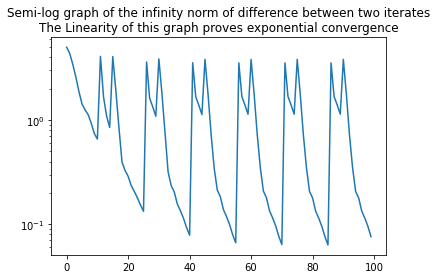

Number of iterations: 100
Last residual 0.07601583626118646


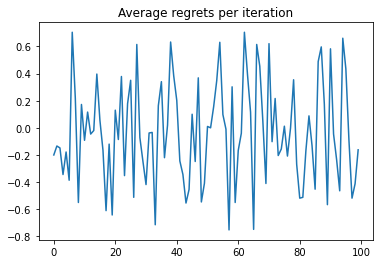

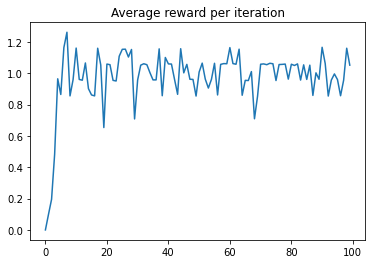

Policy from optimal value iteration
 c= 0: 
	 state(0) = (1, 0)
	 state(1) = (1, 0)
	 state(2) = (0, 0)
	 state(3) = (0, 0)
	 state(4) = (1, 0)
	 state(5) = (1, 0)
	 state(6) = (0, 0)
	 state(7) = (0, 0)
	 state(8) = (1, 0)
	 state(9) = (1, 0)
	 state(10) = (0, 0)
	 state(11) = (0, 0)
	 state(12) = (1, 0)
	 state(13) = (1, 0)
	 state(14) = (0, 0)
	 state(15) = (0, 0)
	 state(16) = (1, 0)
	 state(17) = (1, 0)
	 state(18) = (0, 0)
	 state(19) = (0, 0)
	 state(20) = (0, 0)
	 state(21) = (0, 0)
	 state(22) = (0, 0)
	 state(23) = (0, 0)
c= 1: 
	 state(0) = (1, 0)
	 state(1) = (0, 0)
	 state(2) = (0, 0)
	 state(3) = (0, 0)
	 state(4) = (1, 0)
	 state(5) = (0, 0)
	 state(6) = (0, 0)
	 state(7) = (0, 0)
	 state(8) = (1, 0)
	 state(9) = (0, 0)
	 state(10) = (0, 0)
	 state(11) = (0, 0)
	 state(12) = (1, 0)
	 state(13) = (0, 0)
	 state(14) = (0, 0)
	 state(15) = (0, 0)
	 state(16) = (1, 0)
	 state(17) = (0, 0)
	 state(18) = (0, 0)
	 state(19) = (0, 0)
	 state(20) = (0, 0)
	 state(21) = (0, 0)
	 s

In [12]:
H=6
W=4
K=100
G=5
C=0.1
C_o=0.
GAMMA = 0.9
T = 100
max_iter = 100
GAMMA = 0.9
epsilon = 1e-4
c = np.array([0 if i%15 <= 10 else 1 for i in range(max_iter)],dtype=np.int16)
pi = Policy(garden_1.nS[0]*garden_1.nS[1],(2,2), [0,1])
pi.pi[0] = [(0,1)]*garden_1.nS[0]*garden_1.nS[1]
pi.pi[1] = [(0,1)]*garden_1.nS[0]*garden_1.nS[1]
V_opt, delta_linf,pi.pi,rewards,regrets = value_function_optimal(garden_1,c,pi.pi,epsilon, max_iter,GAMMA)

print(f"Optimal value function with c_t=0 and gamma={GAMMA} with time horizon 1:\n{V_opt}")

plt.figure()
plt.title("Semi-log graph of the infinity norm of difference between \
two iterates\nThe Linearity of this graph proves exponential convergence")
plt.semilogy(delta_linf)
plt.show()
print("Number of iterations:", delta_linf.size)
print("Last residual", delta_linf[-1])
plt.figure()
plt.title("Average regrets per iteration")
plt.plot(regrets)
plt.show()
plt.figure()
plt.title("Average reward per iteration")
plt.plot(rewards)
plt.show()
print("Policy from optimal value iteration\n", pi)
#max_iter = 10
#pi.pi,tot_iter = policy_iteration(garden_1,pi.pi,c,epsilon, max_iter, GAMMA,T)
#print("Tot iterations", tot_iter)
#print("Policy from policy iteration\n", pi)

**Q4.** What is the value of the game with finite horizon $T$ for an arbitrary sequence ? What is an optimal
policy ? What can be said about the $\gamma$ discounted value of each strategy? Can you compute it easily?

Optimal value function with c_t=0 and gamma=0.5 with time horizon 1:
[[2.43352137e-02 1.05149334e-01 7.96068811e-02 2.46784720e-05]
 [5.18796865e-02 3.03197956e-01 2.43785830e-01 2.46874852e-05]
 [2.29942876e-01 8.51778689e-01 7.46746827e-01 2.48178485e-05]
 [8.25378864e-01 2.29429429e+00 2.28756526e+00 2.57432502e-05]
 [2.38564677e+00 5.73853898e+00 7.00784980e+00 3.01564107e-05]
 [5.01221487e+00 5.05261602e+00 5.03983156e+00 5.00002468e+00]]


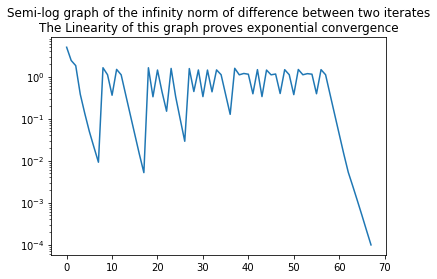

Number of iterations: 68
Last residual 9.880216021240784e-05


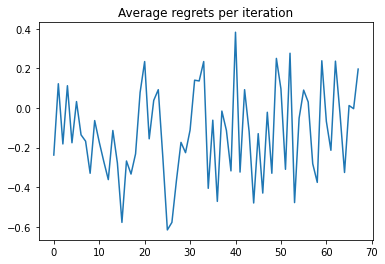

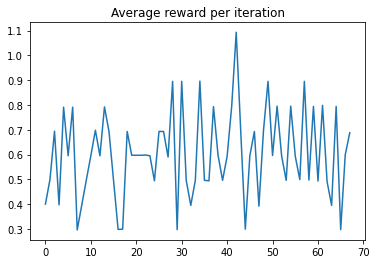

Policy from optimal value iteration
 c= 0: 
	 state(0) = (0, 0)
	 state(1) = (0, 0)
	 state(2) = (0, 0)
	 state(3) = (0, 0)
	 state(4) = (0, 0)
	 state(5) = (1, 0)
	 state(6) = (0, 0)
	 state(7) = (0, 0)
	 state(8) = (0, 0)
	 state(9) = (1, 0)
	 state(10) = (0, 0)
	 state(11) = (0, 0)
	 state(12) = (1, 0)
	 state(13) = (1, 0)
	 state(14) = (0, 0)
	 state(15) = (0, 0)
	 state(16) = (1, 0)
	 state(17) = (1, 0)
	 state(18) = (0, 0)
	 state(19) = (0, 0)
	 state(20) = (0, 0)
	 state(21) = (0, 0)
	 state(22) = (0, 0)
	 state(23) = (0, 0)
c= 1: 
	 state(0) = (0, 0)
	 state(1) = (0, 0)
	 state(2) = (0, 0)
	 state(3) = (0, 0)
	 state(4) = (0, 0)
	 state(5) = (0, 0)
	 state(6) = (0, 0)
	 state(7) = (0, 0)
	 state(8) = (1, 0)
	 state(9) = (0, 0)
	 state(10) = (0, 0)
	 state(11) = (0, 0)
	 state(12) = (1, 0)
	 state(13) = (0, 0)
	 state(14) = (0, 0)
	 state(15) = (0, 0)
	 state(16) = (1, 0)
	 state(17) = (0, 0)
	 state(18) = (0, 0)
	 state(19) = (0, 0)
	 state(20) = (0, 0)
	 state(21) = (0, 0)
	 s

In [13]:
max_iter = 1000
GAMMA = 0.5
epsilon = 1e-4
_,c,_ = rain_generator_E(max_iter)
pi = Policy(garden_1.nS[0]*garden_1.nS[1],(2,2), [0,1])
pi = Policy(garden_1.nS[0]*garden_1.nS[1],(2,2), [0,1])
pi.pi[0] = [(0,1)]*garden_1.nS[0]*garden_1.nS[1]
pi.pi[1] = [(0,1)]*garden_1.nS[0]*garden_1.nS[1]
V_opt, delta_linf,pi.pi,rewards,regrets = value_function_optimal(garden_1,c,pi.pi,epsilon, max_iter,GAMMA)

print(f"Optimal value function with c_t=0 and gamma={GAMMA} with time horizon 1:\n{V_opt}")

plt.figure()
plt.title("Semi-log graph of the infinity norm of difference between \
two iterates\nThe Linearity of this graph proves exponential convergence")
plt.semilogy(delta_linf)
plt.show()
print("Number of iterations:", delta_linf.size)
print("Last residual", delta_linf[-1])
plt.figure()
plt.title("Average regrets per iteration")
plt.plot(regrets)
plt.show()
plt.figure()
plt.title("Average reward per iteration")
plt.plot(rewards)
plt.show()
print("Policy from optimal value iteration\n", pi)
#max_iter = 10
#pi.pi,tot_iter = policy_iteration(garden_1,pi.pi,c,epsilon, max_iter, GAMMA,T)
#print("Tot iterations", tot_iter)
#print("Policy from policy iteration\n", pi)

**We now consider the (P) situation and the Fully-observed model.**

**Q5.** If $\theta_t = \theta$ is constant and known a head of time. What is the value of the game with finite horizon T? With discount $\gamma$? How does it change with $\theta$?

Value function of the always watering policy with constant theta =0.5 and gamma=0.9:
[ 8.42147727e-01  3.54679110e+00 -1.48378573e+01  1.25000000e-01
 -5.20869865e+01  1.32740506e+01 -2.61071347e+00  1.25000000e-01
  9.95228485e+00  9.81708273e+00 -5.36010133e-01  1.25000000e-01
 -1.30376655e+01 -2.67333061e-01 -9.30051055e-02  1.25000000e-01
  1.26154868e+01  4.61845589e-01  7.23250451e-02  1.25000000e-01
  5.75793295e+01  8.19211199e+01 -8.35407154e+01  5.11250000e+01]
Value estimate of the starting point: 0.842
Value function of the always not watering policy with constant theta=0.5 and gamma=0.9:
[   1.16270528  -16.06255809   -2.47909246    1.14002062   -3.67756599
   21.00817705  -35.65596672   42.91913542    0.96417098   -3.24066867
   13.03936715  -43.02706228   -0.86366216    3.02745728  -18.20443054
   65.14092038    2.75825035  -11.91131833   37.82982719 -105.26097402
   60.46434749  -94.5630228    27.68816789   60.26018557]
Value estimate of the starting point: 1.163
Optima

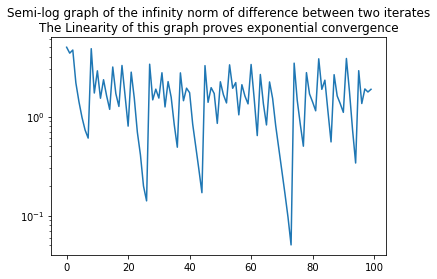

Number of iterations: 100
Last residual 1.8821708059768607


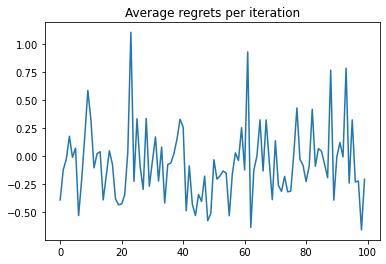

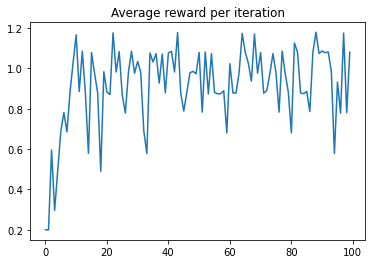

Policy from optimal value iteration
 c= 0: 
	 state(0) = (1, 0)
	 state(1) = (1, 0)
	 state(2) = (0, 0)
	 state(3) = (0, 0)
	 state(4) = (1, 0)
	 state(5) = (1, 0)
	 state(6) = (0, 0)
	 state(7) = (0, 0)
	 state(8) = (1, 0)
	 state(9) = (1, 0)
	 state(10) = (0, 0)
	 state(11) = (0, 0)
	 state(12) = (1, 0)
	 state(13) = (1, 0)
	 state(14) = (0, 0)
	 state(15) = (0, 0)
	 state(16) = (1, 0)
	 state(17) = (1, 0)
	 state(18) = (0, 0)
	 state(19) = (0, 0)
	 state(20) = (0, 0)
	 state(21) = (0, 0)
	 state(22) = (0, 0)
	 state(23) = (0, 0)
c= 1: 
	 state(0) = (1, 0)
	 state(1) = (0, 0)
	 state(2) = (0, 0)
	 state(3) = (0, 0)
	 state(4) = (1, 0)
	 state(5) = (0, 0)
	 state(6) = (0, 0)
	 state(7) = (0, 0)
	 state(8) = (1, 0)
	 state(9) = (0, 0)
	 state(10) = (0, 0)
	 state(11) = (0, 0)
	 state(12) = (1, 0)
	 state(13) = (0, 0)
	 state(14) = (0, 0)
	 state(15) = (0, 0)
	 state(16) = (1, 0)
	 state(17) = (0, 0)
	 state(18) = (0, 0)
	 state(19) = (0, 0)
	 state(20) = (0, 0)
	 state(21) = (0, 0)
	 s

In [14]:
H=6
W=4
K=100
G=5
C=0.1
C_o=0.
GAMMA = 0.9
T = 10
max_iter = 100
GAMMA = 0.9
epsilon = 1e-4
garden_1 = garden(n_plants=1, H=H, W=W, K=K, G=G, C=C,C_o=C_o,rain_gen = rain_generator_E)

thetas,_,_ =rain_generator_P(max_iter)
pi = Policy(garden_1.nS[0]*garden_1.nS[1],(2,2), [0,1])
pi.pi[0] = [(1,1)]*garden_1.nS[0]*garden_1.nS[1]
pi.pi[1] = [(1,1)]*garden_1.nS[0]*garden_1.nS[1]
V_simple_pi = value_function(garden_1,thetas[0:T],pi.pi,GAMMA,T,istheta=True)
print(f"Value function of the always watering policy with constant theta ={thetas[0]} and gamma={GAMMA}:\n{V_simple_pi}")
print(f"Value estimate of the starting point: {V_simple_pi[0]:.3f}")

pi.pi[0] = [(0,1)]*garden_1.nS[0]*garden_1.nS[1]
pi.pi[1] = [(0,1)]*garden_1.nS[0]*garden_1.nS[1]
V_simple_pi = value_function(garden_1,thetas[0:T],pi.pi,GAMMA,T,istheta=True)
print(f"Value function of the always not watering policy with constant theta={thetas[0]} and gamma={GAMMA}:\n{V_simple_pi}")
print(f"Value estimate of the starting point: {V_simple_pi[0]:.3f}")

V_opt, delta_linf, pi.pi,rewards,regrets = value_function_optimal(garden_1,thetas,pi.pi,epsilon, max_iter,GAMMA,istheta=True)
print(f"Optimal value function with constant theta={thetas[0]} and gamma={GAMMA}:\n{V_opt}")

plt.figure()
plt.title("Semi-log graph of the infinity norm of difference between \
two iterates\nThe Linearity of this graph proves exponential convergence")
plt.semilogy(delta_linf)
plt.show()
print("Number of iterations:", delta_linf.size)
print("Last residual", delta_linf[-1])
plt.figure()
plt.title("Average regrets per iteration")
plt.plot(regrets)
plt.show()
plt.figure()
plt.title("Average reward per iteration")
plt.plot(rewards)
plt.show()
print("Policy from optimal value iteration\n", pi)
#max_iter = 10
#pi.pi,tot_iter = policy_iteration(garden_1,pi.pi,c,epsilon, max_iter, GAMMA,T)
#print("Tot iterations", tot_iter)
#print("Policy from policy iteration\n", pi)

**Q6.** We now assume that $\theta_t = \theta$ when $(tmod15)\leq 10$ and $\theta_t = \theta^{'}$ else. What is the value of the game with finite horizon T? With discount $\gamma$?

Optimal value function with changing theta and gamma=0.9:
[[1.37613169 2.03778349 2.40847401 1.98614074]
 [1.46763485 2.6920663  3.10541402 2.22495892]
 [1.84672425 3.41296248 3.83117875 2.79026365]
 [2.40200979 4.14478949 4.56522549 3.45848411]
 [3.05464905 4.95954159 5.41996032 4.16015087]
 [3.37613169 3.80123254 4.11846553 3.67738291]]


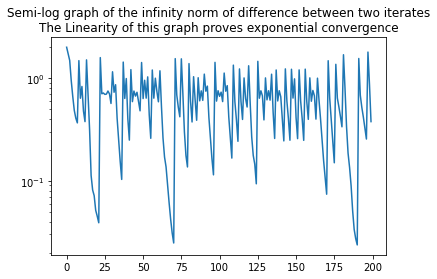

Number of iterations: 200
Last residual 0.37718017770968926


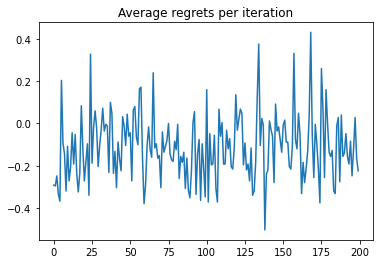

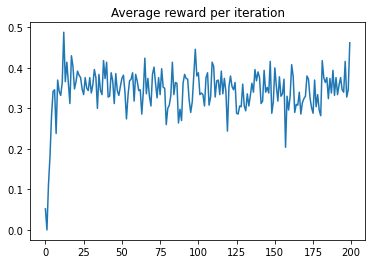

Policy from optimal value iteration
 c= 0: 
	 state(0) = (0, 0)
	 state(1) = (1, 0)
	 state(2) = (0, 0)
	 state(3) = (0, 0)
	 state(4) = (1, 0)
	 state(5) = (1, 0)
	 state(6) = (0, 0)
	 state(7) = (0, 0)
	 state(8) = (1, 0)
	 state(9) = (1, 0)
	 state(10) = (0, 0)
	 state(11) = (0, 0)
	 state(12) = (1, 0)
	 state(13) = (1, 0)
	 state(14) = (0, 0)
	 state(15) = (0, 0)
	 state(16) = (1, 0)
	 state(17) = (1, 0)
	 state(18) = (0, 0)
	 state(19) = (0, 0)
	 state(20) = (0, 0)
	 state(21) = (0, 0)
	 state(22) = (0, 0)
	 state(23) = (0, 0)
c= 1: 
	 state(0) = (0, 0)
	 state(1) = (0, 0)
	 state(2) = (0, 0)
	 state(3) = (0, 0)
	 state(4) = (1, 0)
	 state(5) = (0, 0)
	 state(6) = (0, 0)
	 state(7) = (0, 0)
	 state(8) = (1, 0)
	 state(9) = (0, 0)
	 state(10) = (0, 0)
	 state(11) = (0, 0)
	 state(12) = (1, 0)
	 state(13) = (0, 0)
	 state(14) = (0, 0)
	 state(15) = (0, 0)
	 state(16) = (1, 0)
	 state(17) = (0, 0)
	 state(18) = (0, 0)
	 state(19) = (0, 0)
	 state(20) = (0, 0)
	 state(21) = (0, 0)
	 s

In [15]:
H=6
W=4
K=100
G=2
C=0.2
C_o=0.
GAMMA = 0.9
max_iter = 200
epsilon = 1e-4
T = 20
garden_1 = garden(n_plants=1, H=H, W=W, K=K, G=G, C=C,C_o=C_o,rain_gen = rain_generator_E)

a = np.ones(garden_1.nS,dtype=np.int16)
tmp1,_,_ = rain_generator_P(1)
tmp2,_,_ = rain_generator_P(1)
while tmp1[0] == tmp2[0]:
    tmp2,_,_ = rain_generator_P(1)

thetas=[tmp1[0] if i%15<=10 else tmp2[0] for i in range(max_iter)]
pi = Policy(garden_1.nS[0]*garden_1.nS[1],(2,2), [0,1])

V_opt, delta_linf, pi.pi,rewards,regrets = value_function_optimal(garden_1,thetas,pi.pi,epsilon, max_iter,GAMMA,istheta=True)
print(f"Optimal value function with changing theta and gamma={GAMMA}:\n{V_opt}")

plt.figure()
plt.title("Semi-log graph of the infinity norm of difference between \
two iterates\nThe Linearity of this graph proves exponential convergence")
plt.semilogy(delta_linf)
plt.show()
print("Number of iterations:", delta_linf.size)
print("Last residual", delta_linf[-1])
plt.figure()
plt.title("Average regrets per iteration")
plt.plot(regrets)
plt.show()
plt.figure()
plt.title("Average reward per iteration")
plt.plot(rewards)
plt.show()
print("Policy from optimal value iteration\n", pi)
#max_iter = 10
#pi.pi,tot_iter = policy_iteration(garden_1,pi.pi,c,epsilon, max_iter, GAMMA,T)
#print("Tot iterations", tot_iter)
#print("Policy from policy iteration\n", pi)

**We now consider the (C) situation and the Fully-observed model**

**Q7.** Assume that $\theta_t^{-}, \theta_t^{+},\alpha_t$ are constants. What is the value of the game in the best scenario?What about the worst scenario?

Value function of the always watering policy with constant interval =(0.024114573435863873, 0.3056019218348669, 0.6311954929696273) and gamma=0.9:
[-1.59105834e-01  6.03316248e+01 -1.36219527e+02  1.00000000e-01
  3.05874890e+01 -7.17362919e+01  1.04576040e+02  1.57142857e-01
 -3.83257326e+01  6.98342806e+01 -1.12932510e+02  2.65306122e-02
  1.04530365e+01 -1.91724802e+01  2.58305650e+02 -6.19664703e+02
 -8.13677176e+01  5.94189540e+01 -1.44176480e+02  7.96997476e+02
  4.85680475e+01  5.92984623e+02 -1.17597574e+03  5.09000000e+01]
Value estimate of the starting point: -0.159
Value function of the always not watering policy with constant interval=(0.024114573435863873, 0.3056019218348669, 0.6311954929696273) and gamma=0.9:
[ 2.99211067e+00 -1.91716720e+01  2.18111140e+00 -2.67930398e+00
 -8.65012616e-01 -6.09983879e-01  8.24377059e+00 -2.13935518e+01
  4.89495866e-01 -9.89082736e-01  2.27483743e+00  2.23335410e+01
 -5.39587836e-03 -1.08209061e+00  3.46469432e+00 -8.03863432e+01
 -2.193

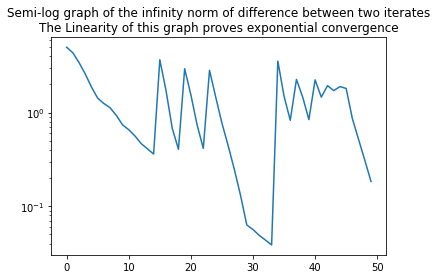

Number of iterations: 50
Last residual 0.18443950069262804


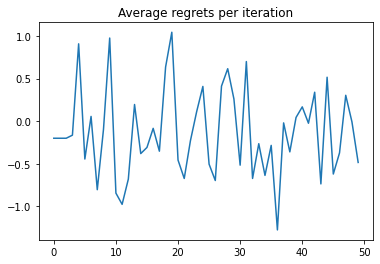

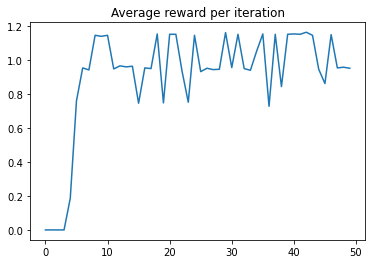

Policy from optimal value iteration
 c= 0: 
	 state(0) = (1, 0)
	 state(1) = (1, 0)
	 state(2) = (0, 0)
	 state(3) = (0, 0)
	 state(4) = (1, 0)
	 state(5) = (1, 0)
	 state(6) = (0, 0)
	 state(7) = (0, 0)
	 state(8) = (1, 0)
	 state(9) = (1, 0)
	 state(10) = (0, 0)
	 state(11) = (0, 0)
	 state(12) = (1, 0)
	 state(13) = (1, 0)
	 state(14) = (0, 0)
	 state(15) = (0, 0)
	 state(16) = (1, 0)
	 state(17) = (1, 0)
	 state(18) = (0, 0)
	 state(19) = (0, 0)
	 state(20) = (0, 0)
	 state(21) = (0, 0)
	 state(22) = (0, 0)
	 state(23) = (0, 0)
c= 1: 
	 state(0) = (1, 0)
	 state(1) = (0, 0)
	 state(2) = (0, 0)
	 state(3) = (0, 0)
	 state(4) = (1, 0)
	 state(5) = (0, 0)
	 state(6) = (0, 0)
	 state(7) = (0, 0)
	 state(8) = (1, 0)
	 state(9) = (0, 0)
	 state(10) = (0, 0)
	 state(11) = (0, 0)
	 state(12) = (1, 0)
	 state(13) = (0, 0)
	 state(14) = (0, 0)
	 state(15) = (0, 0)
	 state(16) = (1, 0)
	 state(17) = (0, 0)
	 state(18) = (0, 0)
	 state(19) = (0, 0)
	 state(20) = (0, 0)
	 state(21) = (0, 0)
	 s

In [17]:
H=6
W=4
K=100
G=5
C=0.1
C_o=0.
GAMMA = 0.9
T = 10
max_iter = 50
GAMMA = 0.9
epsilon = 1e-4
garden_1 = garden(n_plants=1, H=H, W=W, K=K, G=G, C=C,C_o=C_o,rain_gen = rain_generator_E)

thetas,_,_ =rain_generator_P(max_iter)
_,_,conf=rain_generator_C(max_iter)
pi = Policy(garden_1.nS[0]*garden_1.nS[1],(2,2), [0,1])
V_simple_pi = value_function(garden_1,thetas[0:T],pi.pi,GAMMA,T,istheta=True,conf=conf[0:T])
print(f"Value function of the always watering policy with constant interval ={conf[0]} and gamma={GAMMA}:\n{V_simple_pi}")
print(f"Value estimate of the starting point: {V_simple_pi[0]:.3f}")

pi.pi[0] = [(0,1)]*garden_1.nS[0]*garden_1.nS[1]
pi.pi[1] = [(0,1)]*garden_1.nS[0]*garden_1.nS[1]
V_simple_pi = value_function(garden_1,thetas[0:T],pi.pi,GAMMA,T,istheta=True,conf=conf[0:T])
print(f"Value function of the always not watering policy with constant interval={conf[0]} and gamma={GAMMA}:\n{V_simple_pi}")
print(f"Value estimate of the starting point: {V_simple_pi[0]:.3f}")

V_opt, delta_linf, pi.pi,rewards,regrets = value_function_optimal(garden_1,thetas,pi.pi,epsilon, max_iter,GAMMA,istheta=True,conf=conf)
print(f"Optimal value function with constant theta={thetas[0]} and gamma={GAMMA}:\n{V_opt}")

plt.figure()
plt.title("Semi-log graph of the infinity norm of difference between \
two iterates\nThe Linearity of this graph proves exponential convergence")
plt.semilogy(delta_linf)
plt.show()
print("Number of iterations:", delta_linf.size)
print("Last residual", delta_linf[-1])
plt.figure()
plt.title("Average regrets per iteration")
plt.plot(regrets)
plt.show()
plt.figure()
plt.title("Average reward per iteration")
plt.plot(rewards)
plt.show()
print("Policy from optimal value iteration\n", pi)
#max_iter = 10
#pi.pi,tot_iter = policy_iteration(garden_1,pi.pi,c,epsilon, max_iter, GAMMA,T)
#print("Tot iterations", tot_iter)
#print("Policy from policy iteration\n", pi)

**We now consider Partially-observed model**

**Q8.** How are the previous answers modified in this case? What is the influence of $C^{'}$?

See report

**In all the previous questions, the dynamics and rewards were assumed perfectly known. We now assume the
rewards are known, but the dynamics isn’t.**

**Q9.** Adapt the Reinforcement Learning strategies of your choice in order to learn an optimal policy in
each of the previously considered situations. Plot the regret under various situations, and compare against
possible alternatives.

In [18]:
def QL(env,C,pi,max_iter,T, GAMMA=0.9,threshold=1e-4,istheta=False, conf=None):

    Q = np.zeros((env.nS[0]*env.nS[1],env.nA[0],env.nA[1]))
    Q_old = np.zeros((env.nS[0]*env.nS[1],env.nA[0],env.nA[1]))
    vi = np.zeros((env.nS[0]*env.nS[1]))
    delta_linf = np.zeros((max_iter))
    i = 0
    stop = False
    regrets = np.zeros((max_iter))
    rewards = np.zeros((max_iter))
    actionspossible = [(a,o) for a,o in itertools.product(range(env.nA[0]), range(env.nA[1]))]
    
    while i < max_iter and stop==False:
        lambdaa = 1.
        epsilon = 1.
        c = C[i]
        for h,w in itertools.product(range(env.nS[0]), range(env.nS[1])):
            state = h*env.nS[1] + w
            t = 0 
            curr_state = state
            while t < T:
                p = np.random.uniform(0,1)
                a = np.random.choice(env.nA[0],1)[0]
                o = np.random.choice(env.nA[1],1)[0]
                confidence = conf[t] if conf is not None else None
                rain = c[t] if istheta==False else observe_rain(c[t],confidence)
                new_s, r = env.dynamics_from_state(curr_state, a,rain, o, True)
                if p >= epsilon:
                    a, o = np.unravel_index(np.argmax(Q[curr_state]), Q[curr_state].shape)
                    new_s, r = env.dynamics_from_state(curr_state, a, rain, o)
                Q[curr_state,a,o] = lambdaa*(r+ GAMMA*np.max(Q[new_s,:])) + (1-lambdaa)*Q[curr_state,a,o]
                lambdaa = lambdaa*0.99
                epsilon = epsilon*0.99
                #print(t,'-->',state,curr_state,new_s,a)
                pi[rain][curr_state] = np.unravel_index(np.argmax(Q[curr_state]), Q[curr_state].shape)
                curr_state = new_s
                t+=1
            vi[state] = np.max(Q[state])
        delta_linf[i] = np.max(np.abs(Q-Q_old))
        np.copyto(Q_old, Q)
        regrets[i] = average_regret(env,0, pi,c,istheta, conf)
        rewards[i] = average_reward(env,0, pi,c,istheta, conf)
        if delta_linf[i] < threshold:
            delta_linf = delta_linf[:i+1]
            stop = True
        i+=1             
    return vi,pi,delta_linf,rewards,regrets

Q-Value function of the always watering policy with c_t=[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8] and gamma=0.9, with time horizon = 20:
[ 7.41733361  8.40857951  8.57743961  7.67880628  8.73354102 10.4248555
  9.25777202  7.73182176  9.17783387 10.65083434 10.20827678  7.75165959
 12.00790334 14.69246845 14.43393146  7.97353828 13.78953563 16.66689946
 17.32917115 10.45918055 12.3701831  13.62637044 13.32653535 12.0269525 ]
Q-Value estimate of the starting point: 7.417
policy is: 
c= 0: 
	 state(0) = (0, 1)
	 state(1) = (1, 0)
	 state(2) = (0, 0)
	 state(3) = (0, 0)
	 state(4) = (1, 0)
	 state(5) = (0, 0)
	 state(6) = (0, 1)
	 state(7) = (0, 1)
	 state(8) = (1, 0)
	 state(9) = (0, 0)
	 state(10) = (0, 0)
	 state(11) = (0, 0)
	 state(12) = (1, 0)
	 state(13) = (0, 0)
	 state(14) = (0, 0)
	 state(15) = (0, 1)
	 state(16) = (1, 0)
	 state(17) = (0, 0)
	 state(18) = (0, 0)
	 state(19) = (0, 1)
	 state(20) = (0, 0)
	 state(21) = (1, 0)
	 state(22) =

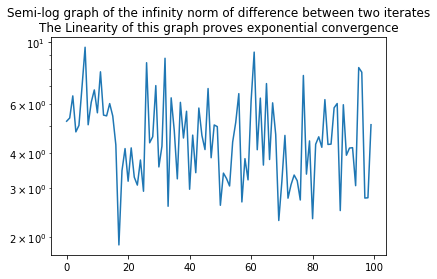

Number of iterations: 100
Last residual 5.062727810293486


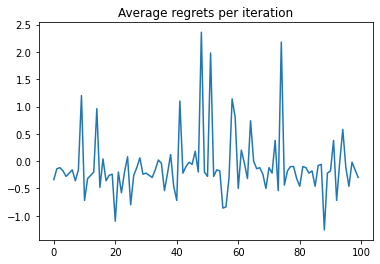

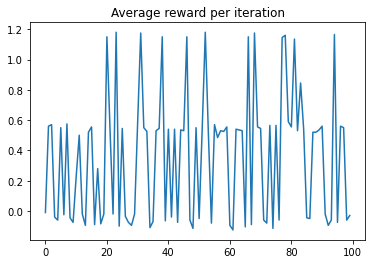

Policy from optimal value iteration
 c= 0: 
	 state(0) = (0, 1)
	 state(1) = (1, 0)
	 state(2) = (0, 0)
	 state(3) = (0, 0)
	 state(4) = (1, 0)
	 state(5) = (0, 0)
	 state(6) = (0, 1)
	 state(7) = (0, 1)
	 state(8) = (1, 0)
	 state(9) = (0, 0)
	 state(10) = (0, 0)
	 state(11) = (0, 0)
	 state(12) = (1, 0)
	 state(13) = (0, 0)
	 state(14) = (0, 0)
	 state(15) = (0, 1)
	 state(16) = (1, 0)
	 state(17) = (0, 0)
	 state(18) = (0, 0)
	 state(19) = (0, 1)
	 state(20) = (0, 0)
	 state(21) = (1, 0)
	 state(22) = (1, 0)
	 state(23) = (1, 0)
c= 1: 
	 state(0) = (1, 0)
	 state(1) = (1, 0)
	 state(2) = (0, 0)
	 state(3) = (0, 0)
	 state(4) = (1, 0)
	 state(5) = (0, 0)
	 state(6) = (0, 1)
	 state(7) = (0, 1)
	 state(8) = (1, 0)
	 state(9) = (0, 0)
	 state(10) = (0, 0)
	 state(11) = (0, 0)
	 state(12) = (1, 0)
	 state(13) = (0, 0)
	 state(14) = (0, 0)
	 state(15) = (0, 1)
	 state(16) = (1, 1)
	 state(17) = (0, 0)
	 state(18) = (0, 0)
	 state(19) = (0, 1)
	 state(20) = (0, 0)
	 state(21) = (1, 0)
	 s

In [19]:
H=6
W=4
K=100
G=6
C=0.1
C_o=0.1
GAMMA = 0.9
T = 20
max_iter = 100
garden_1 = garden(n_plants=1, H=H, W=W, K=K, G=G, C=C,C_o=C_o,rain_gen = rain_generator_E, fullmodel=False)
#_,val,_ = rain_generator_E(T)
#c = np.full((max_iter,T),0.5,dtype=np.int16)
c = np.zeros((max_iter,T))
val,_,_ = rain_generator_P(T)
for i in range(c.shape[0]):
    c[i]= val
#tmp1,_,_ = rain_generator_P(1)
#tmp2,_,_ = rain_generator_P(1)
#while tmp1[0] == tmp2[0]:
#    tmp2,_,_ = rain_generator_P(1)
#c = []
#for i in range(max_iter):
 #   c.append([tmp1[0] if i%15<=10 else tmp2[0] for i in range(T)])

pi = Policy(garden_1.nS[0]*garden_1.nS[1],(2,2), [0,1])
pi.pi[0] = [(0,0)]*garden_1.nS[0]*garden_1.nS[1]
pi.pi[1] = [(0,0)]*garden_1.nS[0]*garden_1.nS[1]

V, pi.pi,delta_linf,rewards,regrets = QL(garden_1,c,pi.pi,max_iter,T, GAMMA,istheta=True)
print(f"Q-Value function of the always watering policy with c_t={c[0]} and gamma={GAMMA}, with time horizon = {T}:\n{V}")
print(f"Q-Value estimate of the starting point: {V[0]:.3f}")
print(f"policy is: \n{pi}")
plt.figure()
plt.title("Semi-log graph of the infinity norm of difference between \
two iterates\nThe Linearity of this graph proves exponential convergence")
plt.semilogy(delta_linf)
plt.show()
print("Number of iterations:", delta_linf.size)
print("Last residual", delta_linf[-1])
plt.figure()
plt.title("Average regrets per iteration")
plt.plot(regrets)
plt.show()
plt.figure()
plt.title("Average reward per iteration")
plt.plot(rewards)
plt.show()
print("Policy from optimal value iteration\n", pi)
#max_iter = 10
#pi.pi,tot_iter = policy_iteration(garden_1,pi.pi,c,epsilon, max_iter, GAMMA,T)
#print("Tot iterations", tot_iter)
#print("Policy from policy iteration\n", pi)

Optimal value function with c_t=0 and gamma=0.9 with time horizon 1:
[[ 8.89544639  9.66070204 10.21847951  8.89544639]
 [10.0452903  11.33405931 11.96555296 10.0452903 ]
 [11.73080233 13.2768783  13.99395869 11.73080233]
 [13.76590965 15.53255059 16.3489998  13.76590965]
 [16.37011802 18.15145512 19.08327458 16.37011802]
 [14.47568207 14.69454718 15.19654691 14.47568207]]


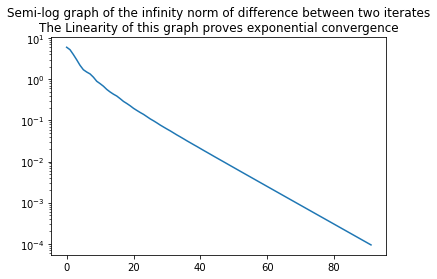

Number of iterations: 92
Last residual 9.407051634546804e-05


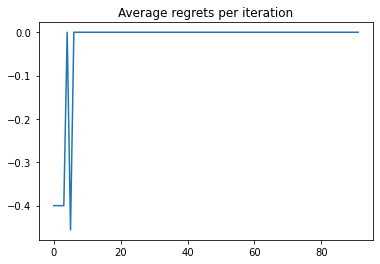

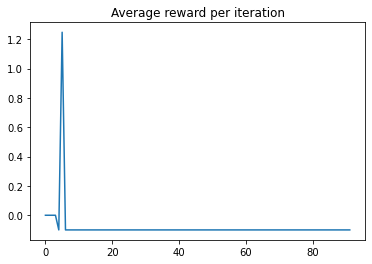

Policy from optimal value iteration
 c= 0: 
	 state(0) = (0, 1)
	 state(1) = (1, 0)
	 state(2) = (0, 0)
	 state(3) = (0, 1)
	 state(4) = (0, 1)
	 state(5) = (1, 0)
	 state(6) = (0, 0)
	 state(7) = (0, 1)
	 state(8) = (0, 1)
	 state(9) = (1, 0)
	 state(10) = (0, 0)
	 state(11) = (0, 1)
	 state(12) = (0, 1)
	 state(13) = (1, 0)
	 state(14) = (0, 0)
	 state(15) = (0, 1)
	 state(16) = (0, 1)
	 state(17) = (1, 0)
	 state(18) = (0, 0)
	 state(19) = (0, 1)
	 state(20) = (0, 1)
	 state(21) = (0, 0)
	 state(22) = (0, 0)
	 state(23) = (0, 1)
c= 1: 
	 state(0) = (1, 0)
	 state(1) = (1, 1)
	 state(2) = (0, 0)
	 state(3) = (0, 1)
	 state(4) = (0, 1)
	 state(5) = (0, 0)
	 state(6) = (0, 0)
	 state(7) = (1, 1)
	 state(8) = (0, 0)
	 state(9) = (0, 1)
	 state(10) = (0, 1)
	 state(11) = (0, 1)
	 state(12) = (1, 0)
	 state(13) = (0, 1)
	 state(14) = (1, 1)
	 state(15) = (1, 0)
	 state(16) = (1, 0)
	 state(17) = (1, 1)
	 state(18) = (1, 1)
	 state(19) = (1, 1)
	 state(20) = (0, 1)
	 state(21) = (0, 0)
	 s

In [20]:
H=6
W=4
K=100
G=6
C=0.1
C_o=0.1
GAMMA = 0.9
T = 100
epsilon = 1e-4
garden_1 = garden(n_plants=1, H=H, W=W, K=K, G=G, C=C,C_o=C_o,rain_gen = rain_generator_E, fullmodel=False)

_,c,_ = rain_generator_E(max_iter)
pi = Policy(garden_1.nS[0]*garden_1.nS[1],(2,2), [0,1])

max_iter = 1000
c = np.zeros(max_iter,dtype=np.int16)
V_opt, delta_linf,pi.pi,rewards,regrets = value_function_optimal(garden_1,c,pi.pi,epsilon, max_iter,GAMMA)
print(f"Optimal value function with c_t={c[0]} and gamma={GAMMA} with time horizon 1:\n{V_opt}")

plt.figure()
plt.title("Semi-log graph of the infinity norm of difference between \
two iterates\nThe Linearity of this graph proves exponential convergence")
plt.semilogy(delta_linf)
plt.show()
print("Number of iterations:", delta_linf.size)
print("Last residual", delta_linf[-1])
plt.figure()
plt.title("Average regrets per iteration")
plt.plot(regrets)
plt.show()
plt.figure()
plt.title("Average reward per iteration")
plt.plot(rewards)
plt.show()
print("Policy from optimal value iteration\n", pi)
#max_iter = 10
#pi.pi,tot_iter = policy_iteration(garden_1,pi.pi,c,epsilon, max_iter, GAMMA,T)
#print("Tot iterations", tot_iter)
#print("Policy from policy iteration\n", pi)

**Q10.** In the previous questions, the goal was to target an optimal value defined in expectation. You
now want to take into account the variability of the system into account, and want a risk-averse rather than
risk-neutral decision. Using the CVAR criterion, how do you suggest to modify the previous strategies?
What results do you get?


##  The optimal sowing plant problem

In this section, we consider the rain forecast (either in (E), (P) or (C) mode) is given ahead of time with
infinite look-ahead $(L = \infty)$.
We consider the farmer has the possibility to choose the time when to sow the plant, hence when to start
the experiment. For simplicity, we assume that $\theta_t$ can only take three values, \{0.1, 0.5, 0.8\}, and consider $\theta_t$ is piecewise constant with each epoch having size $K$.
We assume the farmer always follows an optimal policy $\pi^*$ after the sowing date. The action of the
farmer is now to choose which day to sow the plant $d\in \{1, . . . , T\}$.

**Q1.**  For a sowing date $d$, What is the value of the game in the (E) case ? in the (P) case ?

In [21]:
def value_function_sow(env,state,d,pi,c,GAMMA=1., T=20,istheta=False, conf = None):
    assert(d<T and d>=0)
    v = 0.
    curr_state=state
    V_opt = np.zeros(env.nS)
    V_old = np.zeros(env.nS)
    while d < T:
        confidence = conf[d] if conf is not None else None
        rain = c[d] if istheta==False else observe_rain(c[d],confidence)
        a = pi[rain][curr_state][0]
        o = pi[rain][curr_state][1]
        confidence = conf[t] if conf is not None else None
        rain = c[d] if istheta==False else observe_rain(c[d],confidence)
        new_s, r = env.dynamics_from_state(curr_state, a,rain, o, True)
        V_opt[int(curr_state/env.nS[1]),int(curr_state%env.nS[1])] += r + GAMMA*V_old[int(new_s/env.nS[1]),int(new_s%env.nS[1])]
        curr_state = new_s
        d+=1
    return V_opt

def optimal_iteration_sow(env,pi,rain,epsilon, GAMMA=1., T=30,istheta=False, conf = None):
    V_pi = np.zeros((T,env.nS[0],env.nS[1]))
    maxv = np.zeros((T))
    stop = False
    i = 0
    rain_history = []
    action_history = []
    c = rain
    if istheta == True:
        for i in range(len(rain)):
            confidence = conf[i] if conf is not None else None
            c[i] = observe_rain(rain[i],confidence)
    c = np.array(c).astype(np.int16)
    bestw = 0
    while (not stop) and (i < T):
        bestw = estimate_w_level(rain_history,action_history,env.nS[1])
        V_pi[i] = value_function_sow(env,bestw,i,pi,c,GAMMA, T)
        maxv[i] = V_pi[i,0,0]
        i += 1
        rain_history.append(c[i])
        action_history.append(0)
    return V_pi[np.argmax(maxv)],np.argmax(maxv), bestw,rain_history[0:np.argmax(maxv)+1]

(E) case

In [22]:
H=6
W=4
K=100
G=5
C=0.1
C_o=0.
GAMMA = 0.9
T = 100
max_iter = 100
GAMMA = 0.9
epsilon = 1e-4
garden_1 = garden(n_plants=1, H=H, W=W, K=K, G=G, C=C,C_o=C_o,rain_gen = rain_generator_E)
_,c,_ = rain_generator_E(max_iter)
pi = Policy(garden_1.nS[0]*garden_1.nS[1],(2,2), [0,1])
pi.pi[0] = [(0,1)]*garden_1.nS[0]*garden_1.nS[1]
pi.pi[1] = [(0,1)]*garden_1.nS[0]*garden_1.nS[1]
V_opt, delta_linf,pi.pi,rewards,regrets = value_function_optimal(garden_1,c,pi.pi,epsilon, max_iter,GAMMA)

In [23]:
value_function_sow(garden_1,0,5,pi.pi,c,GAMMA, T)

array([[-0.2, -0.9,  0. ,  0. ],
       [ 0. , -0.2,  0. ,  0. ],
       [ 0. , -0.8,  0. ,  0. ],
       [ 0. , -0.9,  0. ,  0. ],
       [ 0. , 29.5, 25. ,  0. ],
       [ 0. , 30. , 20. ,  0. ]])

**Q2.** Compute an optimal value and sowing date $d^*$, given a plant-watering dynamical problem formulation.

In [25]:
optimal_iteration_sow(garden_1,pi.pi,c,GAMMA, T)

(array([[-0.1,  0. ,  0. ,  0. ],
        [ 0. , -0.2,  0. ,  0. ],
        [ 0. , -0.1,  0. ,  0. ],
        [ 0. , -0.2,  0. ,  0. ],
        [ 0. , -0.4, 10. ,  0. ],
        [ 0. , 10. ,  0. ,  0. ]]),
 0,
 0,
 [1])

##  The many-plant watering problem

**Q1.** Consider the case when $M = 2$ and $V = 1$. In the (E) situation with constant context vector, what is the optimal value of the game?

**Q2.** What do you suggest to solve the problem of action allocation in this case? In the general case?